# Example 1: Detecting an obvious outlier

In [1]:
import numpy as np
from isotree import IsolationForest

### Random data from a standard normal distribution
np.random.seed(1)
n = 100
m = 2
X = np.random.normal(size = (n, m))

### Will now add obvious outlier point (3, 3) to the data
X = np.r_[X, np.array([3, 3]).reshape((1, m))]

### Fit a small isolation forest model
iso = IsolationForest(ntrees = 10, ndim = 2, nthreads = 1)
iso.fit(X)

### Check which row has the highest outlier score
pred = iso.predict(X)
print("Point with highest outlier score: ",
      X[np.argsort(-pred)[0], ])

Point with highest outlier score:  [3. 3.]


# Example 2: Plotting outlier and density regions

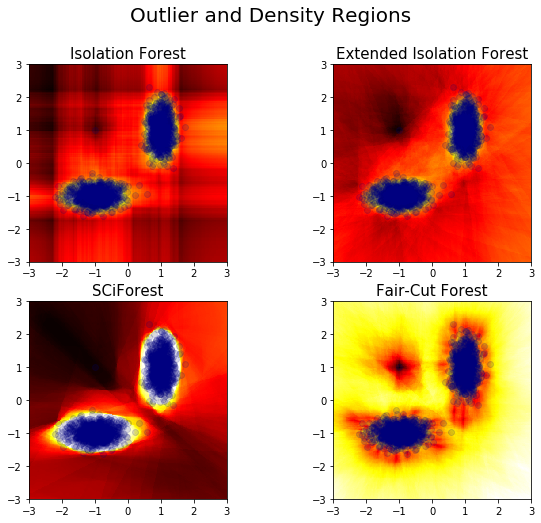

(Note that the upper-left corner has an outlier point,
        and that there is a slight slide in the axes of the heat colors and the points)


In [2]:
import numpy as np, pandas as pd
from isotree import IsolationForest
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10, 8

np.random.seed(1)
group1 = pd.DataFrame({
    "x" : np.random.normal(loc=-1, scale=.4, size = 1000),
    "y" : np.random.normal(loc=-1, scale=.2, size = 1000),
})
group2 = pd.DataFrame({
    "x" : np.random.normal(loc=+1, scale=.2, size = 1000),
    "y" : np.random.normal(loc=+1, scale=.4, size = 1000),
})
X = pd.concat([group1, group2], ignore_index=True)

### Now add an obvious outlier which is within the 1d ranges
### (As an interesting test, remove it and see what happens)
X = X.append(pd.DataFrame({"x" : [-1], "y" : [1]}), ignore_index = True)

### Single-variable Isolatio Forest
iso_simple = IsolationForest(ndim=1, ntrees=100, prob_pick_pooled_gain=0)
iso_simple.fit(X)

### Extended Isolation Forest
iso_ext = IsolationForest(ndim=2, ntrees=100, prob_pick_pooled_gain=0)
iso_ext.fit(X)

### SCiForest
iso_sci = IsolationForest(ndim=2, ntrees=100, prob_pick_avg_gain=1, prob_pick_pooled_gain=0)
iso_sci.fit(X)

### Fair-Cut Forest
iso_fcf = IsolationForest(ndim=2, ntrees=100, prob_pick_avg_gain=0, prob_pick_pooled_gain=1)
iso_fcf.fit(X)

### Plot as a heatmap
pts = np.linspace(-3, 3, 250)
space = np.array( np.meshgrid(pts, pts) ).reshape((2, -1)).T
Z_sim = iso_simple.predict(space)
Z_ext = iso_ext.predict(space)
Z_sci = iso_sci.predict(space)
Z_fcf = iso_fcf.predict(space)
space_index = pd.MultiIndex.from_arrays([space[:, 0], space[:, 1]])

def plot_space(Z, space_index, X):
    df = pd.DataFrame({"z" : Z}, index = space_index)
    df = df.unstack()
    df = df[df.columns.values[::-1]]
    plt.imshow(df, extent = [-3, 3, -3, 3], cmap = 'hot_r')
    plt.scatter(x = X['x'], y = X['y'], alpha = .15, c = 'navy')

plt.suptitle("Outlier and Density Regions", fontsize = 20)

plt.subplot(2, 2, 1)
plot_space(Z_sim, space_index, X)
plt.title("Isolation Forest", fontsize=15)

plt.subplot(2, 2, 2)
plot_space(Z_ext, space_index, X)
plt.title("Extended Isolation Forest", fontsize=15)

plt.subplot(2, 2, 3)
plot_space(Z_sci, space_index, X)
plt.title("SCiForest", fontsize=15)

plt.subplot(2, 2, 4)
plot_space(Z_fcf, space_index, X)
plt.title("Fair-Cut Forest", fontsize=15)
plt.show()

print("(Note that the upper-left corner has an outlier point,\n\
        and that there is a slight slide in the axes of the heat colors and the points)")

# Example 3: calculating pairwise distances

In [3]:
import numpy as np, pandas as pd
from isotree import IsolationForest
from scipy.spatial.distance import cdist

### Generate random multivariate-normal data
np.random.seed(1)
n = 1000
m = 10

### This is a random PSD matrix to use as covariance
S = np.random.normal(size = (m, m))
S = S.T.dot(S)

mu = np.random.normal(size = m, scale = 2)
X = np.random.multivariate_normal(mu, S, n)

### Fitting the model
iso = IsolationForest(prob_pick_avg_gain=0, prob_pick_pooled_gain=0)
iso.fit(X)

### Calculate approximate distance
D_sep = iso.predict_distance(X, square_mat = True)

### Compare against other distances
D_euc = cdist(X, X, metric = "euclidean")
D_cos = cdist(X, X, metric = "cosine")
D_mah = cdist(X, X, metric = "mahalanobis")

### Correlations
print("Correlations between different distance metrics")
pd.DataFrame(
    np.corrcoef([D_sep.reshape(-1), D_euc.reshape(-1), D_cos.reshape(-1), D_mah.reshape(-1)]),
    columns = ['SeparaionDepth', 'Euclidean', 'Cosine', 'Mahalanobis'],
    index   = ['SeparaionDepth', 'Euclidean', 'Cosine', 'Mahalanobis']
)

Correlations between different distance metrics


,SeparaionDepth,Euclidean,Cosine,Mahalanobis
SeparaionDepth,1.000000,0.974024,0.722591,0.735249
Euclidean,0.974024,1.000000,0.760075,0.728392
Cosine,0.722591,0.760075,1.000000,0.554319
Mahalanobis,0.735249,0.728392,0.554319,1.000000


# Example 4: imputing missing values

In [4]:
import numpy as np
from isotree import IsolationForest

### Generate random multivariate-normal data
np.random.seed(1)
n = 1000
m = 5

### This is a random PSD matrix to use as covariance
S = np.random.normal(size = (m, m))
S = S.T.dot(S)

mu = np.random.normal(size = m)
X = np.random.multivariate_normal(mu, S, n)

### Set some values randomly as missing
values_NA = (np.random.random(size = n * m) <= .15).reshape((n, m))
X_na = X.copy()
X_na[values_NA] = np.nan

### Fitting the model
iso = IsolationForest(build_imputer=True, prob_pick_pooled_gain=1, ntry=10)
iso.fit(X_na)

### Impute missing values
X_imputed = iso.transform(X_na)
print("MSE for imputed values w/model: %f\n" % np.mean((X[values_NA] - X_imputed[values_NA])**2))

### Comparison against simple mean imputation
X_means = np.nanmean(X_na, axis = 0)
X_imp_mean = X_na.copy()
for cl in range(m):
    X_imp_mean[np.isnan(X_imp_mean[:,cl]), cl] = X_means[cl]
    
print("MSE for imputed values w/means: %f\n" % np.mean((X[values_NA] - X_imp_mean[values_NA])**2))

MSE for imputed values w/model: 3.176113

MSE for imputed values w/means: 5.540559

